# Kaggle House Price Prediction: Advanced Regression
### Project Goal:
Predict the final price of each home using 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

### Skills Demonstrated:
* Data Cleaning & Imputation
* Feature Encoding (One-Hot Encoding)
* Linear Regression Modeling
* Model Evaluation (RMSE)

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# for reproducibility
tf.random.set_seed(42)
np.set_printoptions(precision=3, suppress=True)

## 2. Load the Data

In [2]:
# Load dataset
train_df = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')

# Drop the 'Id' column as it's not a predictor
train_df.drop('Id', axis=1, inplace=True)

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3. Simplified Data Cleaning

In [3]:
# Drop columns with more than 80% missing values
train_df = train_df.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

# Drop rows where 'SalePrice' is missing
train_df = train_df.dropna(subset=['SalePrice'])

# Separate numerical and categorical columns
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train_df.select_dtypes(include=['object']).columns

# Fill missing numerical values with median
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

# Fill missing categorical values with "None"
train_df[cat_cols] = train_df[cat_cols].fillna('None')

print(f'Numerical Columns {len(num_cols)}:\n', '\t'.join(num_cols), '\n')
print(f'Categorical Columns {len(cat_cols)}:\n', '\t'.join(cat_cols), '\n')

Numerical Columns 37:
 MSSubClass	LotFrontage	LotArea	OverallQual	OverallCond	YearBuilt	YearRemodAdd	MasVnrArea	BsmtFinSF1	BsmtFinSF2	BsmtUnfSF	TotalBsmtSF	1stFlrSF	2ndFlrSF	LowQualFinSF	GrLivArea	BsmtFullBath	BsmtHalfBath	FullBath	HalfBath	BedroomAbvGr	KitchenAbvGr	TotRmsAbvGrd	Fireplaces	GarageYrBlt	GarageCars	GarageArea	WoodDeckSF	OpenPorchSF	EnclosedPorch	3SsnPorch	ScreenPorch	PoolArea	MiscVal	MoSold	YrSold	SalePrice 

Categorical Columns 39:
 MSZoning	Street	LotShape	LandContour	Utilities	LotConfig	LandSlope	Neighborhood	Condition1	Condition2	BldgType	HouseStyle	RoofStyle	RoofMatl	Exterior1st	Exterior2nd	MasVnrType	ExterQual	ExterCond	Foundation	BsmtQual	BsmtCond	BsmtExposure	BsmtFinType1	BsmtFinType2	Heating	HeatingQC	CentralAir	Electrical	KitchenQual	Functional	FireplaceQu	GarageType	GarageFinish	GarageQual	GarageCond	PavedDrive	SaleType	SaleCondition 



## 4. Feature Engineering

In [4]:
# New features
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
train_df['TotalBath'] = (train_df['FullBath'] + 0.5 * train_df['HalfBath'] + train_df['BsmtFullBath'] + 0.5 * train_df['BsmtHalfBath'])
train_df['Age'] = train_df['YrSold'] - train_df['YearBuilt']
train_df['IsRemodeled'] = (train_df['YearBuilt'] != train_df['YearRemodAdd']).astype(int)
train_df['TotalPorchSF'] = (train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['3SsnPorch'] + train_df['ScreenPorch'])
# Log scale the target variable to reduce skewness
train_df['SalePrice_Log'] = np.log1p(train_df['SalePrice'])

### Correlation Matrix

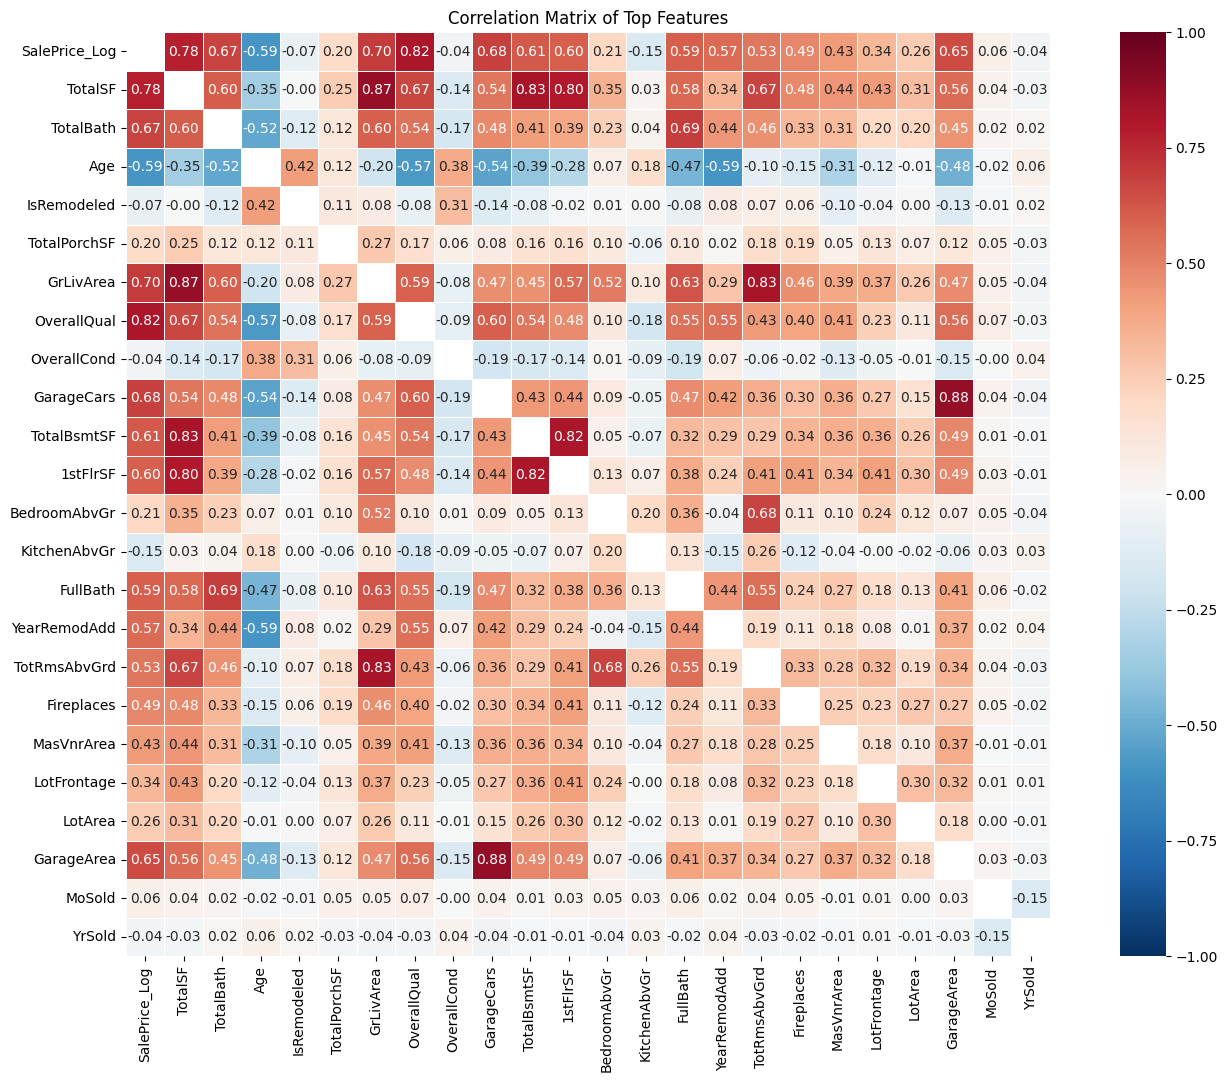

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the list of features to analyze
corr_features = [
    'SalePrice_Log', 'TotalSF', 'TotalBath', 'Age', 'IsRemodeled', 'TotalPorchSF', 'GrLivArea',
    'OverallQual', 'OverallCond', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'BedroomAbvGr', 'KitchenAbvGr',
    'FullBath', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 
    'MasVnrArea', 'LotFrontage', 'LotArea', 'GarageArea', 'MoSold', 'YrSold'
]

# 2. Calculate the correlation matrix
corrmat = train_df[corr_features].corr()

# 3. Create a mask for the diagonal (self-correlation)
mask = np.eye(len(corrmat), dtype=bool)

# 4. Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corrmat, annot=True, fmt='.2f', cmap='RdBu_r', square=True, 
            mask=mask, vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('Correlation Matrix of Top Features')
plt.show()

In [6]:
# 1. Select features based on correlation analysis
columns_to_keep = [
    # Target Variable
    'SalePrice_Log',
    # Numerical Features : From correlation analysis
    'TotalSF', 'TotalBath', 'Age', 'TotalPorchSF', 'OverallQual', 'GarageCars', 'BedroomAbvGr', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea',
    # Categorical Features : Domain knowledge
    'Neighborhood', 'Foundation', 'CentralAir', 'HouseStyle', 'SaleCondition',
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond'
] 

# 2. Prepare the final dataset
train_df = train_df[columns_to_keep]

## 5. Feature Encoding

In [7]:
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}

# List of columns that use this specific scale
ord_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
            'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

for col in ord_cols:
    train_df[col] = train_df[col].map(quality_map)

# Convert 'CentralAir' to binary
train_df['CentralAir'] = train_df['CentralAir'].map({'Y': 1, 'N': 0})

# Create dummy variables for categorical data. Using One-Hot Encoding
train_final = pd.get_dummies(train_df)

print(f"Final Data Shape after Encoding: {train_final.shape}")

Final Data Shape after Encoding: (1460, 67)


## 6. Model Training & HyperParameter Tuning

In [8]:
from sklearn.preprocessing import StandardScaler

# Define Features (X) and Target (y)
X = train_final.drop('SalePrice_Log', axis=1)
y = train_final['SalePrice_Log']

# Add scaling to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split: 60% train, 20% cv (cross-validation), 20% test
X_train, X_cv_test, y_train, y_cv_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_cv_test, y_cv_test, test_size=0.5, random_state=42)

print(f"Training Set Shape: {X_train.shape}, {y_train.shape}")
print(f"CV Set Shape: {X_cv.shape}, {y_cv.shape}")

Training Set Shape: (876, 66), (876,)
CV Set Shape: (292, 66), (292,)


First let's try Random Forest Regressor

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold

parameter_grid = {
    'n_estimators': [500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [1, 2, 5]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=parameter_grid,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

# Evaluate on CV set
y_cv_pred = best_rf_model.predict(X_cv)
cv_mse = mean_squared_error(y_cv, y_cv_pred)
cv_rmse = np.sqrt(cv_mse)

print(f"\nBest Hyperparameters: {grid_search.best_params_}")
print(f"CV RMSE: {cv_rmse}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
CV RMSE: 0.16029237632476945


Let's try XGBoost

In [10]:
from xgboost import XGBRegressor

# Hyperparameter tuning for XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

parameter_grid_xgb = {
    'n_estimators': [500],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameter_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)

best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate on CV set with early stopping
best_xgb_model.set_params(early_stopping_rounds=10)
best_xgb_model.fit(X_train, y_train, eval_set=[(X_cv, y_cv)], verbose=False)

y_cv_pred_xgb = best_xgb_model.predict(X_cv)
cv_mse_xgb = mean_squared_error(y_cv, y_cv_pred_xgb)
cv_rmse_xgb = np.sqrt(cv_mse_xgb)

print(f"\nBest Hyperparameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"CV RMSE for XGBoost: {cv_rmse_xgb}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Hyperparameters for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.7}
CV RMSE for XGBoost: 0.15386687487518705


Let's try with Neural Networks

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

NN_Architectures = {
    'Baseline' : [128, 64, 1],
    'Funnel' : [256, 128, 64, 1],
    'Wide' : [512, 512, 1],
    'Deep' : [256, 64, 256, 1],
    'Very_Deep' : [256, 256, 256, 256, 1]
}

def build_nn_model(architecture, input_dim):
    model = Sequential()
    model.add(Dense(architecture[0], input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    for units in architecture[1:-1]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
    model.add(Dense(architecture[-1], activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

input_dim = X_train.shape[1]

# Callbacks for better training
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

model_rmses = {}

for name, architecture in NN_Architectures.items():
    print(f"\nTraining Neural Network Architecture: {name}")
    nn_model = build_nn_model(architecture, input_dim)
    nn_model.fit(X_train, y_train, epochs=500, batch_size=32, 
                 validation_data=(X_cv, y_cv), callbacks=[early_stop, reduce_lr], verbose=0)
    y_cv_pred_nn = nn_model.predict(X_cv, verbose=0)
    cv_mse_nn = mean_squared_error(y_cv, y_cv_pred_nn)
    cv_rmse_nn = np.sqrt(cv_mse_nn)
    print(f"CV RMSE for {name}: {cv_rmse_nn}")
    model_rmses[name] = (cv_rmse_nn, nn_model)

# Find the best model based on CV RMSE
best_model_name = min(model_rmses, key=lambda x: model_rmses[x][0])
best_nn_model = model_rmses[best_model_name][1]

print(f"\nBest Neural Network Architecture: {best_model_name} with CV RMSE: {model_rmses[best_model_name][0]}")


Training Neural Network Architecture: Baseline
CV RMSE for Baseline: 0.2616954497372426

Training Neural Network Architecture: Funnel
CV RMSE for Funnel: 11.715454008023828

Training Neural Network Architecture: Wide
CV RMSE for Wide: 11.176401041026137

Training Neural Network Architecture: Deep
CV RMSE for Deep: 11.522395354130035

Training Neural Network Architecture: Very_Deep
CV RMSE for Very_Deep: 11.564354036583648

Best Neural Network Architecture: Baseline with CV RMSE: 0.2616954497372426


Let's compare the results among best models

In [12]:
def get_accuracy_metrics(models_dict, X_val, y_val_log):
    # Convert log-target back to actual price
    y_actual = np.expm1(y_val_log)
    
    results = []
    for name, model in models_dict.items():
        # Get log-predictions and convert back
        preds_log = model.predict(X_val)
        # Flatten predictions (Neural Networks return 2D arrays)
        preds_log = np.array(preds_log).flatten()
        preds_actual = np.expm1(preds_log)
        
        # Calculate Percentage Error
        mape = np.mean(np.abs((y_actual - preds_actual) / y_actual)) * 100
        accuracy = 100 - mape
        
        results.append({"Model": name, "RMSE": np.sqrt(mean_squared_error(y_val_log, preds_log)), "Accuracy %": accuracy})
    
    return pd.DataFrame(results)

In [15]:
models = {
    "Random Forest": best_rf_model,
    "XGBoost": best_xgb_model,
    "Neural Network": best_nn_model
}

print("-- Performance on the test data set --")
print(get_accuracy_metrics(models, X_test, y_test))

-- Performance on the test data set --
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
            Model      RMSE  Accuracy %
0   Random Forest  0.120826   91.088712
1         XGBoost  0.115496   91.478935
2  Neural Network  0.297185   77.581921


## Ensempling the models

In [19]:
# weighted average predictions
rf_weight = 0.25
xgb_weight = 0.7
nn_weight = 0.05

# Calculate weighted predictions
y_test_pred_rf = best_rf_model.predict(X_test)
y_test_pred_xgb = best_xgb_model.predict(X_test)
y_test_pred_nn = best_nn_model.predict(X_test).flatten()

y_test_ensemble_pred = (rf_weight * y_test_pred_rf +
                        xgb_weight * y_test_pred_xgb +
                        nn_weight * y_test_pred_nn) 

# Calculate RMSE for ensemble
ensemble_mse = mean_squared_error(y_test, y_test_ensemble_pred)
ensemble_rmse = np.sqrt(ensemble_mse)

print(f"\nEnsembled Model RMSE on Test Set: {ensemble_rmse}")
# Accuracy Percentage
y_test_actual = np.expm1(y_test)
y_test_ensemble_actual = np.expm1(y_test_ensemble_pred)
mape_ensemble = np.mean(np.abs((y_test_actual - y_test_ensemble_actual) / y_test_actual)) * 100
accuracy_ensemble = 100 - mape_ensemble 
print(f"Ensembled Model Accuracy on Test Set: {accuracy_ensemble}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Ensembled Model RMSE on Test Set: 0.11731118811102409
Ensembled Model Accuracy on Test Set: 91.25383582768143%


## Feature Importance Visualization

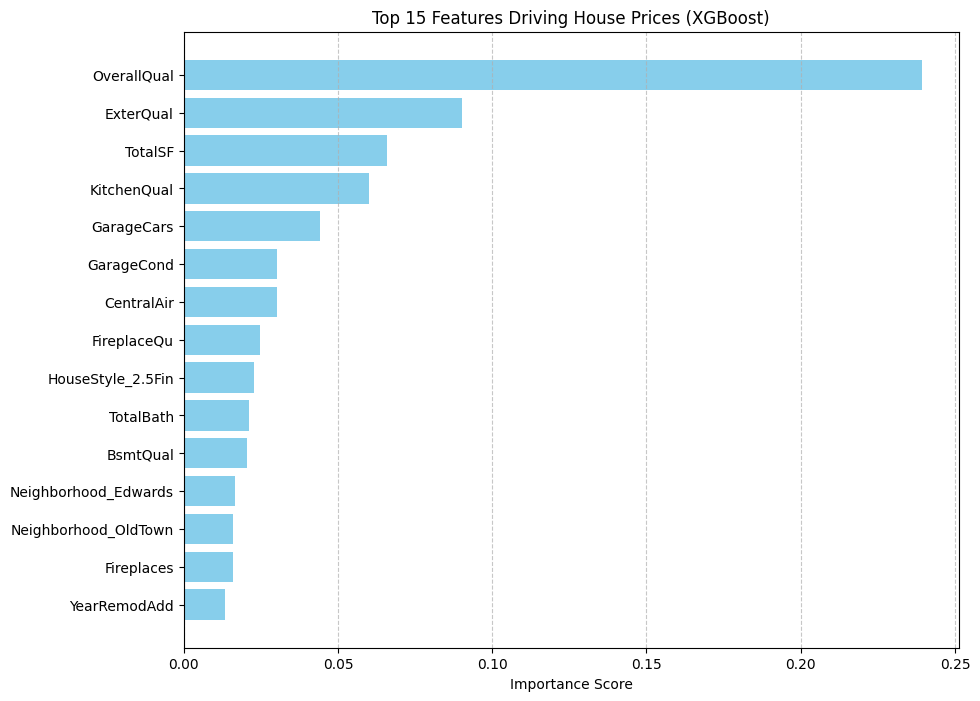

In [16]:
import matplotlib.pyplot as plt

# 1. Get the feature importance scores
importances = best_xgb_model.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame for sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plot the Top 15 Features
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:15][::-1], 
         feature_importance_df['Importance'][:15][::-1], 
         color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 15 Features Driving House Prices (XGBoost)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## The Residual Plot

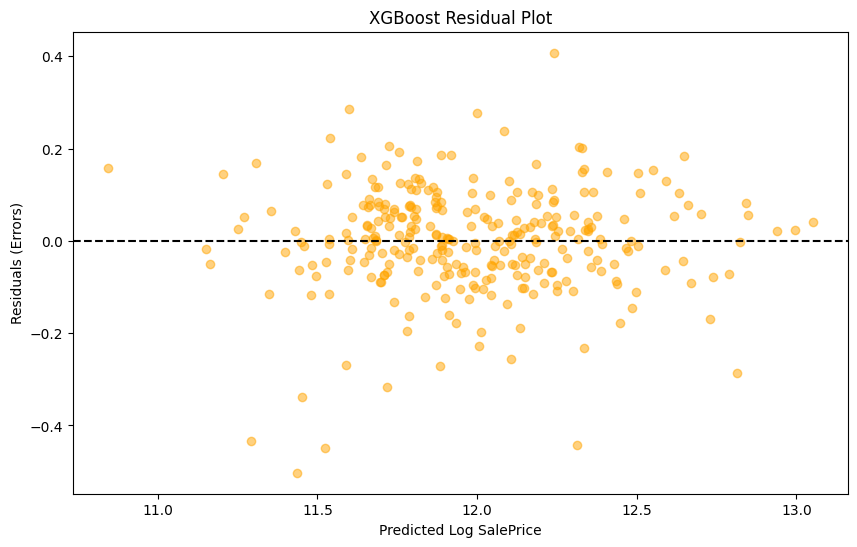

In [18]:
# Calculate residuals for the validation set
y_val_preds = best_xgb_model.predict(X_test)
residuals =  y_test - y_val_preds

plt.figure(figsize=(10, 6))
plt.scatter(y_val_preds, residuals, alpha=0.5, color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Log SalePrice')
plt.ylabel('Residuals (Errors)')
plt.title('XGBoost Residual Plot')
plt.show()

## SHAP Summary Plot

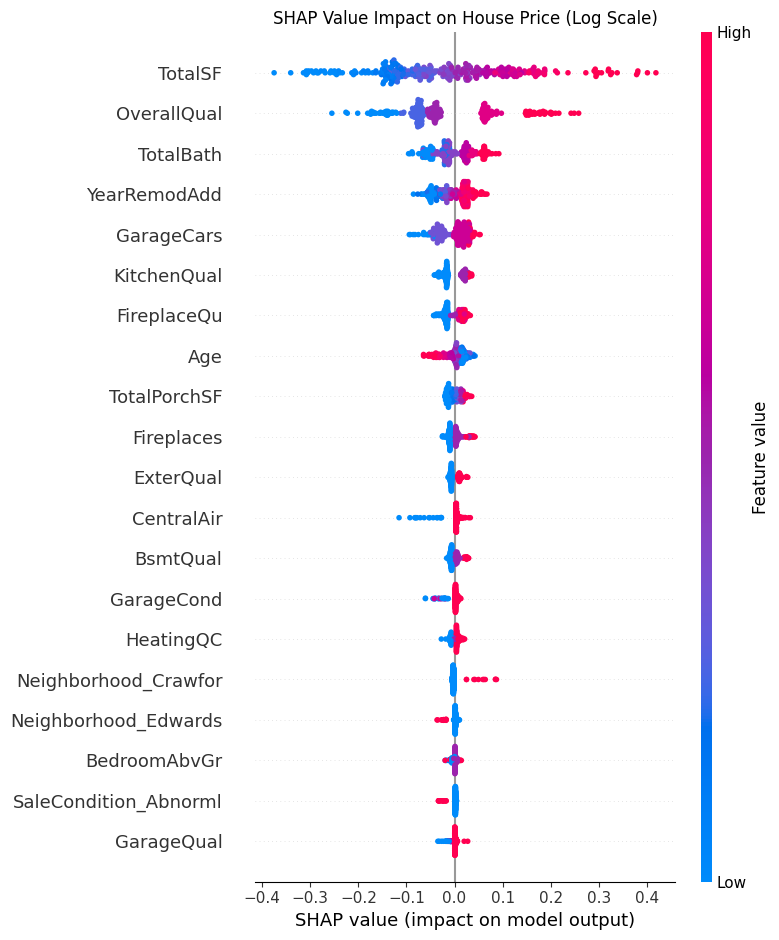

In [22]:
import shap

# 1. Initialize the SHAP explainer with your best XGBoost model
explainer = shap.TreeExplainer(best_xgb_model)

# 2. Calculate SHAP values for your validation set
# (Using a subset if your test set is very large, but 1460 is fine)
shap_values = explainer.shap_values(X_test)

# 3. Generate the Summary Plot
plt.title('SHAP Value Impact on House Price (Log Scale)')
shap.summary_plot(shap_values, X_test, feature_names=X.columns)